---
title: Deforestation Monitoring using Sentinel 2 and xarray
subtitle: Streamlining Cloud-Based Processing with EOPF and Xarray
authors:
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
  - name: Tina Erica Odaka
    orcid: 0000-0002-1500-0156
    github: tinaok
    affiliations:
      - id: IFREMER
        institution: French Research Institute for Exploitation of the Sea
        ror: 044jxhp58
date: 2025-01-29
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords : earth and related environmental sciences
releaseDate: 2025-03-04
datePublished: 2025-03-04
dateModified: 2025-03-04
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Area of Interest](#Area-of-Interest)
- [Data Access with EOPF Zarr](#Data-Access-with-EOPF-Zarr)
- [Read data with xarray](#Read-data-with-xarray)
- [Analysis](#Analysis)
- [Validation](#Validation)
- [Summary](#Summary)

(Introduction)=
## Introduction

Sentinel 2 data is one of the most popular satellite datasets, but it does come with challenges. Cloud-free mosaics have to be constructed often in order to get analysis-ready data. Accessing a lot of data through tiles takes a long time, and getting the data into a format it can be easily analysed in with common Python tools can be a challenge.

In this notebook, we will show how this whole process of getting analysis-ready data into Python can be sped up by using the Copernicus Dataspace Ecosystem and Sentinel Hub APIs. This is being presented by running through a basic deforestation monitoring use-case. The notebook uses the popular xarray Python library to handle the multidimensional data.

:::{hint} Overview
**Questions**
- How can we access Sentinel-2 data efficiently?
- How can we compute vegetation indices like NDVI in the cloud?
- How can we generate cloud-free mosaics for better analysis?
- How can we analyze changes in vegetation over time?
- How can we efficiently handle large EO datasets in Python?
- How can we classify deforested areas from satellite data?
- How can we evaluate the reliability of our classification?
  
**Objectives**
- Accessing Sentinel-2 data in the Copernicus Dataspace Ecosystem.
- Performing NDVI calculations using cloud-based processing.
- Creating monthly composites from Sentinel-2 data.
- Building a time series for deforestation monitoring.
- Loading and managing data using the Xarray library.
- Applying threshold-based classification techniques.
- Conducting an accuracy assessment of the classification results.
:::

(Setup)=
## Setup
Start importing the necessary libraries

In [2]:
from pathlib import Path

import requests
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ipyleaflet import Map, Polygon

(Area-of-Interest)=
## Area of Interest

First, we define an area of interest. In this case the area of interest is in the Harz Mountains in Germany since we are aware of substantial forest dieback in recent years.



In [2]:
epsg = 3035

bbox = [10.633501, 51.611195, 10.787234, 51.698098]
center = ((bbox[1] + bbox[3]) / 2.0, (bbox[0] + bbox[2]) / 2.0)
m = Map(center=center, zoom=11)
# Create polygon from lists of points
polygon = Polygon(
    locations=[
        (bbox[1], bbox[0]),
        (bbox[3], bbox[0]),
        (bbox[3], bbox[2]),
        (bbox[1], bbox[2]),
    ],
    color="green",
    fill_color="green",
)

# Add the polygon to the map
m.add(polygon)
m

Map(center=[51.6546465, 10.7103675], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

(Data-Access-with-EOPF-Zarr)=
## Data Access with EOPF Zarr

Now we can load the data into [xarray](https://docs.xarray.dev/en/stable/). We use [rioxarray](https://corteva.github.io/rioxarray/html/index.html), an extension for xarray, to load multiple tiffs into a single xarray dataset.
xarray is a scalable tool for analysing multidimensional data in Python. This makes xarray ideal for analysing time series data.

The different files correspond to the time dimension, but xarray does not know which file is which time step. Therefore, we add a pre-processing step in which we parse out the year from the filename and add it as the time dimension for that file. 

The warnings in the output can be safely ignored.

In [3]:
import s3fs

bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefix = "tutorial_data/cpm_v253/"

# Create the S3FileSystem with a custom endpoint
fs = s3fs.S3FileSystem(
    anon=True, client_kwargs={"endpoint_url": "https://objectstore.eodc.eu:2222"}
)

# unregister handler to make boto3 work with CEPH
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
handler_to_unregister = handlers_to_unregister[0]
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handler_to_unregister
)

s3path = "s3://" + f"{bucket}/{prefix}" + "S2A_MSIL2A*.zarr"
remote_files = fs.glob(s3path)
remote_files[0:5]

['e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180601T102021_N0500_R065_T32UPC_20230902T045008.zarr',
 'e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180604T103021_N0500_R108_T32UPC_20230819T205634.zarr',
 'e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180611T102021_N0500_R065_T32UPC_20230714T225353.zarr',
 'e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180614T103021_N0500_R108_T32UPC_20230813T122609.zarr',
 'e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180621T102021_N0500_R065_T32UPC_20230827T073006.zarr']

In [4]:
import os

prefix = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253"

coder = xr.coders.CFTimedeltaCoder(time_unit="s")
remote_product_path = prefix + "/" + os.path.basename(remote_files[0])
dset = xr.open_datatree(
    remote_product_path, engine="zarr", chunks={}, decode_timedelta=coder
)
dset["measurements/reflectance"]

/srv/conda/envs/eopf-xarray/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


<xarray.DataTree 'reflectance'>
Group: /measurements/reflectance
├── Group: /measurements/reflectance/r10m
│       Dimensions:  (y: 10980, x: 10980)
│       Coordinates:
│         * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
│         * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
│       Data variables:
│           b02      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│           b03      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│           b04      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│           b08      (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
├── Group: /measurements/reflectance/r20m
│       Dimensions:  (y: 5490, x: 5490)
│       Coordinates:
│         * x        (x) int64 44kB 600010 600030 600050 600070 ... 709750 709770 709790
│         * y        (y) int64 44kB 5800010 5799990 5799970 ... 5690270 5690250 5690230
│       Data variables:
│           b01      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b02      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b03      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b04      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b05      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b06      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b07      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b11      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b12      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│           b8a      (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
└── Group: /measurements/reflectance/r60m
        Dimensions:  (y: 1830, x: 1830)
        Coordinates:
          * x        (x) int64 15kB 600030 600090 600150 600210 ... 709650 709710 709770
          * y        (y) int64 15kB 5799990 5799930 5799870 ... 5690370 5690310 5690250
        Data variables:
            b01      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b02      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b03      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b04      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b05      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b06      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b07      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b09      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b11      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b12      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
            b8a      (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>

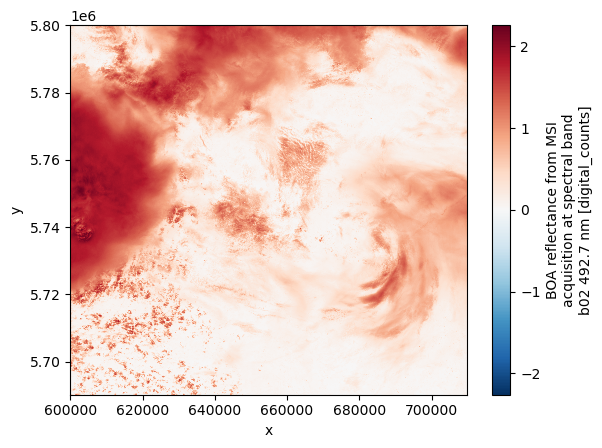

/srv/conda/envs/eopf-xarray/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/srv/conda/envs/eopf-xarray/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/srv/conda/envs/eopf-xarray/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/srv/conda/envs/eopf-xarray/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


In [5]:
dset["measurements/reflectance/r10m"]["b02"].plot()

In [6]:
from datetime import datetime

date_format = "%Y%m%dT%H%M%S"


def validate_scl(scl):
    invalid = [0, 1, 3, 7, 8, 9, 10]  # NO_DATA, SATURATED, CLOUD, etc.
    return ~scl.isin(invalid)


def compute_cloudless_ndvi(dt):
    r10m = dt["measurements/reflectance/r10m"].ds  # Keep as Dask array, no rechunk
    scl_20m = dt["conditions/mask/l2a_classification/r20m"]["scl"].chunk(
        {"x": -1, "y": -1}
    )
    scl_10m = scl_20m.interp(
        x=r10m["x"], y=r10m["y"], method="nearest"
    )  # Upsample SCL to 10m
    valid_mask = validate_scl(scl_10m)  # Boolean mask (10980x10980)

    # Apply mask per pixel, keep spatial dims
    valid_r10m = r10m.where(valid_mask)
    b04 = valid_r10m["b04"]
    b08 = valid_r10m["b08"]
    ndvi = (b08 - b04) / (b08 + b04)  # Per-pixel NDVI

    # Stack bands and NDVI, scale to match Sentinel Hub
    scale = (
        xr.concat(
            [valid_r10m["b04"], valid_r10m["b03"], valid_r10m["b02"], ndvi], dim="bands"
        )
        * 10000
    )
    return scale.assign_coords(bands=["b04", "b03", "b02", "ndvi"])

In [7]:
# Use concat along the time (one time per tile)
results = {}
for filename in remote_files[0:15]:  # first files only because other may be corrupted?
    date_str = os.path.basename(filename).split("_")[2]
    remote_product_path = prefix + "/" + os.path.basename(filename)
    dset = xr.open_datatree(
        remote_product_path, engine="zarr", chunks={}, decode_timedelta=coder
    )
    # Check if r10m.x is all zeros
    r10m_x = dset["measurements/reflectance/r10m"].ds["x"]
    if (r10m_x == 0).all() or r10m_x.max() == r10m_x.min():
        print(f"Skipping {date_str}: Invalid x coords (all zeros or uniform)")
        continue
    ndvi_da = compute_cloudless_ndvi(dset)
    print(f"Time: {date_str}, Shape: {ndvi_da.shape}")
    results[datetime.strptime(date_str, date_format)] = ndvi_da

merged_da = xr.concat(
    list(results.values()), dim="time", coords="minimal", compat="override"
)
merged_da = merged_da.assign_coords(time=list(results.keys()))
print("Merged DataArray:", merged_da)

Time: 20180601T102021, Shape: (4, 10980, 10980)
Time: 20180604T103021, Shape: (4, 10980, 10980)
Time: 20180611T102021, Shape: (4, 10980, 10980)
Time: 20180614T103021, Shape: (4, 10980, 10980)
Time: 20180621T102021, Shape: (4, 10980, 10980)
Time: 20180624T103021, Shape: (4, 10980, 10980)
Time: 20180701T102021, Shape: (4, 10980, 10980)
Time: 20180704T103021, Shape: (4, 10980, 10980)
Time: 20180711T102021, Shape: (4, 10980, 10980)
Time: 20180714T103021, Shape: (4, 10980, 10980)
Time: 20180721T102021, Shape: (4, 10980, 10980)
Time: 20180724T103021, Shape: (4, 10980, 10980)
Time: 20180731T102021, Shape: (4, 10980, 10980)
Time: 20180803T103021, Shape: (4, 10980, 10980)
Time: 20180810T102021, Shape: (4, 10980, 10980)
Merged DataArray: <xarray.DataArray 'b04' (time: 15, bands: 4, y: 10980, x: 10980)> Size: 58GB
dask.array<concatenate, shape=(15, 4, 10980, 10980), dtype=float64, chunksize=(1, 1, 1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 

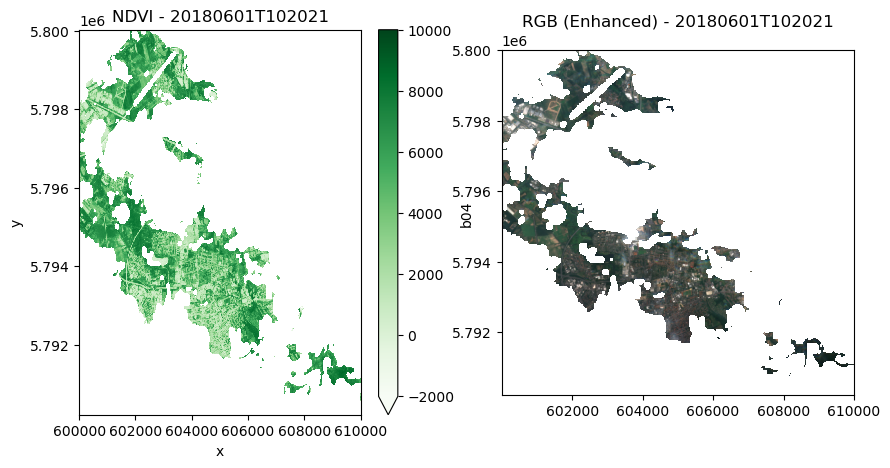

In [8]:
# Select a manageable region (descending y)
region = merged_da.sel(
    time="20180601T102021", x=slice(600005, 610005), y=slice(5800015, 5790225)
)

# NDVI plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
region.sel(bands="ndvi").plot(cmap="Greens", vmin=-2000, vmax=10000)
plt.title("NDVI - 20180601T102021")

# RGB plot with contrast stretch
rgb = region.sel(bands=["b04", "b03", "b02"]).transpose("y", "x", "bands")
rgb = rgb / 10000  # Rescale to reflectance
rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
rgb = rgb.clip(0, 1)  # Clip to valid range
plt.subplot(1, 2, 2)
plt.imshow(rgb, extent=[600005, 610005, 5790225, 5800015])
plt.title("RGB (Enhanced) - 20180601T102021")
plt.gca().set_aspect("equal")
plt.show()

In [9]:
# Group by year and compute mean
yearly_da = merged_da.groupby("time.year").mean(dim="time", skipna=True)
yearly_da

<xarray.DataArray 'b04' (year: 1, bands: 4, y: 10980, x: 10980)> Size: 4GB
dask.array<stack, shape=(1, 4, 10980, 10980), dtype=float64, chunksize=(1, 1, 1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
  * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
  * year     (year) int64 8B 2018

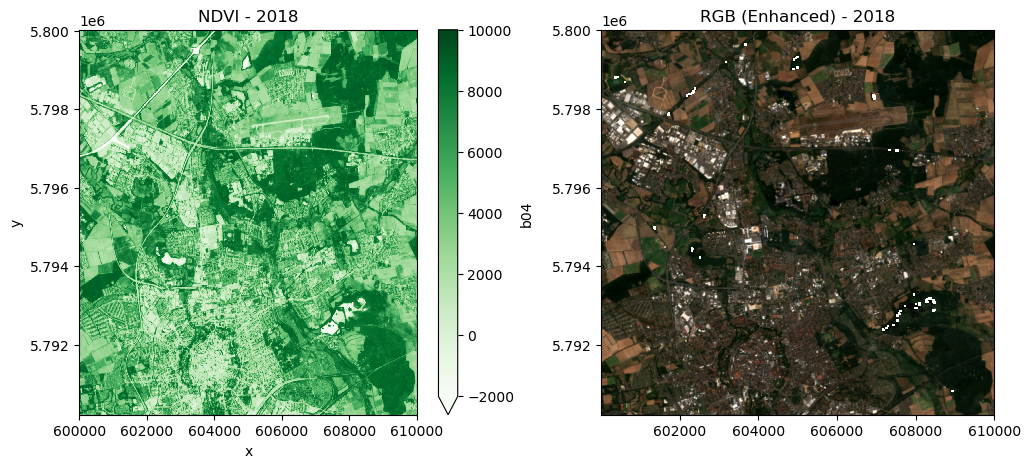

In [10]:
import matplotlib.pyplot as plt

# Select year (descending y)
year = 2018  # Adjust if more years
region = yearly_da.sel(year=year, x=slice(600005, 610005), y=slice(5800015, 5790225))

# NDVI plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
region.sel(bands="ndvi").plot(cmap="Greens", vmin=-2000, vmax=10000)
plt.title(f"NDVI - {year}")

# RGB plot with contrast stretch
rgb = region.sel(bands=["b04", "b03", "b02"]).transpose("y", "x", "bands")
rgb = rgb / 10000
rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch
rgb = rgb.clip(0, 1)
plt.subplot(1, 2, 2)
plt.imshow(rgb, extent=[600005, 610005, 5790225, 5800015])
plt.title(f"RGB (Enhanced) - {year}")
plt.gca().set_aspect("equal")
plt.show()

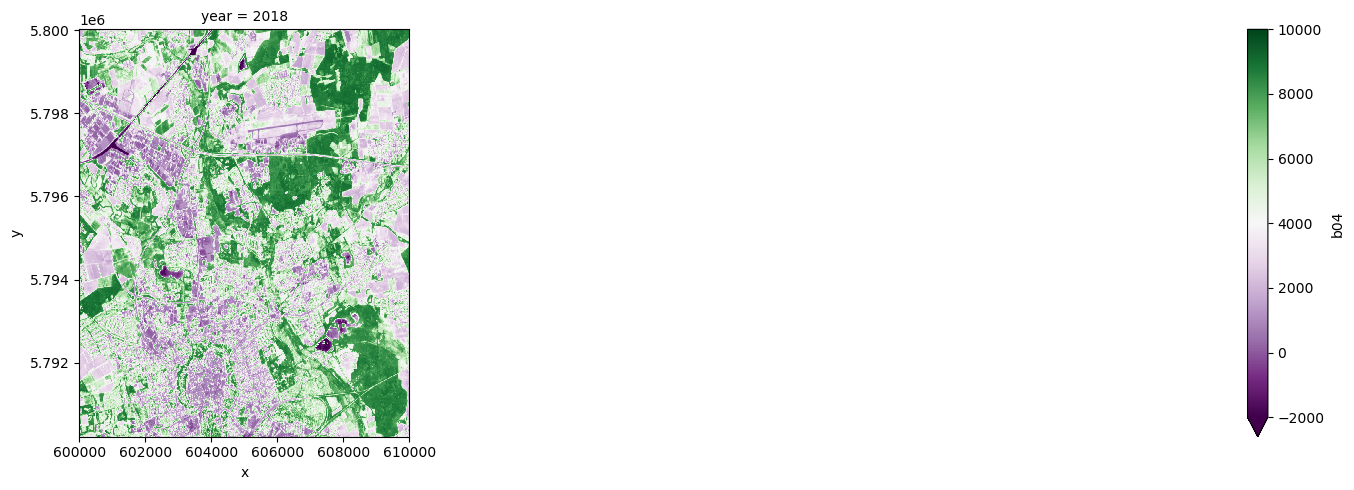

In [11]:
# Select NDVI and plot per year (smaller region for speed)
ndvi_yearly = yearly_da.sel(
    bands="ndvi", x=slice(600005, 610005), y=slice(5800015, 5790225)
)
ndvi_yearly.plot(
    cmap="PRGn",
    x="x",
    y="y",
    col="year",
    col_wrap=3,
    vmin=-2000,
    vmax=10000,
    figsize=(15, 5),
)
plt.show()

## Create Xarray with NDVI and corresponding bands as variables

In [12]:
ndvi_ds = xr.Dataset(
    {
        "NDVI": merged_da.sel(bands="ndvi").drop_vars("bands"),
        "B04": merged_da.sel(bands="b04").drop_vars("bands"),
        "B03": merged_da.sel(bands="b03").drop_vars("bands"),
        "B02": merged_da.sel(bands="b02").drop_vars("bands"),
    }
)
ndvi_ds

<xarray.Dataset> Size: 58GB
Dimensions:  (x: 10980, y: 10980, time: 15)
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
  * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
  * time     (time) datetime64[ns] 120B 2018-06-01T10:20:21 ... 2018-08-10T10...
Data variables:
    NDVI     (time, y, x) float64 14GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    B04      (time, y, x) float64 14GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    B03      (time, y, x) float64 14GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    B02      (time, y, x) float64 14GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

In [13]:
yearly_ds = ndvi_ds.groupby("time.year").mean(dim="time", skipna=True)
yearly_ds

<xarray.Dataset> Size: 4GB
Dimensions:  (year: 1, y: 10980, x: 10980)
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
  * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
  * year     (year) int64 8B 2018
Data variables:
    NDVI     (year, y, x) float64 964MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    B04      (year, y, x) float64 964MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    B03      (year, y, x) float64 964MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    B02      (year, y, x) float64 964MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

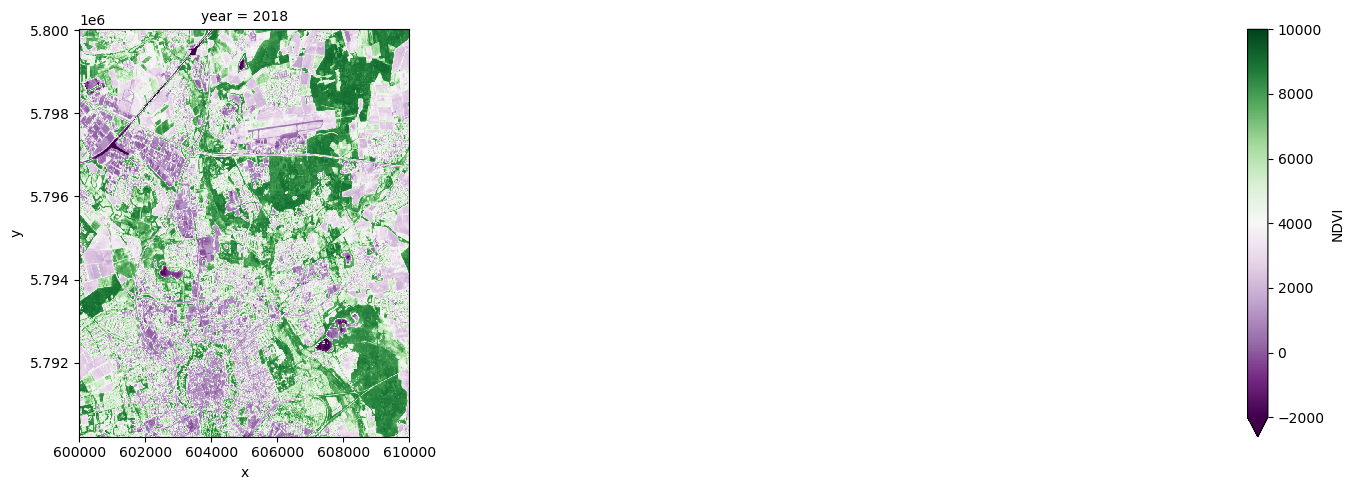

In [14]:
yearly_ds.sel(x=slice(600005, 610005), y=slice(5800015, 5790225))["NDVI"].plot(
    cmap="PRGn",
    x="x",
    y="y",
    col="year",
    col_wrap=3,
    vmin=-2000,
    vmax=10000,
    figsize=(15, 5),
)
plt.show()

## Analysis

For analysis the first step is to classify pixels as forest. In our case we will just do a simple thresholding classification where we classify everything above a certain threshold as forest. This isn't the best approach for classifying forest, since agricultural areas can also easily reach very high NDVI values. A better approach would be to classify based on the temporal signature of the pixel. 

However, for this basic analysis, we stick to the simple thresholding approach.

In this case we classify everything above an NDVI of 0.7 as forest. This calculated forest mask is then saved to a new Data Variable in the xarray dataset: 

In [15]:
yearly_ds["FOREST"] = yearly_ds.NDVI > 0.7

With this forest mask we can already do a quick preliminary analysis to plot the total forest area over the years.

To do this we sum up the pixels along the x and y coordinate but not along the time coordinate. This will leave us with one value per year representing the number of pixels classified as forest. We can then calculate the forest area by multiplying the number of forest pixels by the resolution.

In [16]:
def to_km2(dataarray, resolution):
    # Calculate forest area
    return dataarray * np.prod(list(resolution)) / 1e6


# resolution of our data (should be available form the data)
resolution = (10, 10)
forest_pixels = yearly_ds.FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2.values

array([11980.3161])

In [17]:
forest_area_km2.load()

<xarray.DataArray 'FOREST' (year: 1)> Size: 8B
array([11980.3161])
Coordinates:
  * year     (year) int64 8B 2018

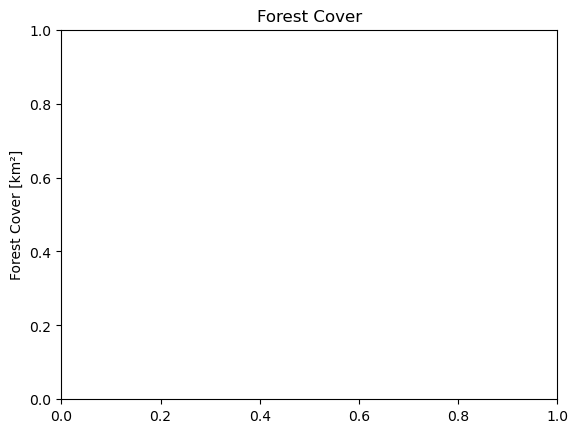

In [18]:
if len(forest_area_km2.values) > 1:
    forest_area_km2.plot()
plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0);

We can see that the total forest area in this AOI decreased from around 80 km² in 2018 to only around 50 km² in 2023.

The next step is to make change maps from year to year. To do this we basically take the difference of the forest mask of a year with its previous year.

This will result in 0 value where there has been no change, -1 where forest was lost and +1 where forest was gained.

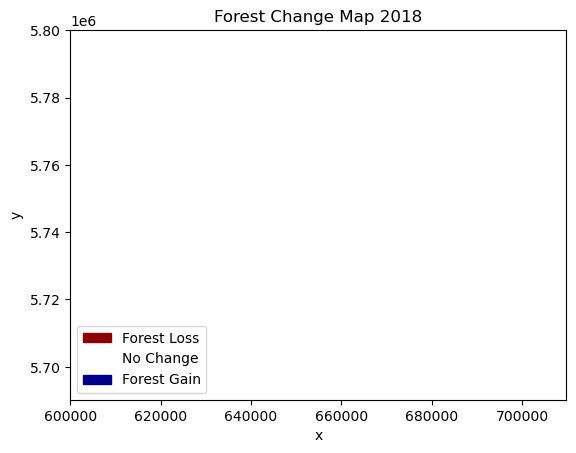

In [19]:
# Make change maps of forest loss and forest gain compared to previous year

# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and normalize it
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)  # Adjust the range based on your data

plot_year = 2018
yearly_ds["CHANGE"] = yearly_ds.FOREST.astype(int).diff("year", label="upper")
yearly_ds.CHANGE.sel(year=plot_year).plot(cmap=cmap, norm=norm, add_colorbar=False)

# Create a legend with string labels
legend_patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {plot_year}");

Here, we can see the spatial distribution of areas affected by forest loss. In the displayed change from 2021 to 2022, most of the forest loss happened in the northern part of the study area, while the southern part lost comparatively less forest.

To get a feel for the loss per year, we can cumulatively sum up the lost areas over the years. This should basically follow the same trends as the earlier plot of total forest area. 

## Validation

Finally, we want to see how accurate our data is compared to the widely used Hansen Global Forest Change data. In a real scientific scenario, we would use Ground Truth data to assess the accuracy of our classification. In this case we use the Global Forest Change data in place of Ground Truth data, just to show how an accuracy assessment can be done. The assessment we are doing only shows how accurately we replicate the Global Forest Change data, however we will not know if our product is more or less accurate. For a more accurate assessment, actual Ground Truth data is required.

First we download the Global Forest Change Data [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html) and open it using xarray.

In [3]:
data_path = Path("./data/")
data_path.mkdir(parents=True, exist_ok=True)
hansen_filename = "Hansen_GFC-2022-v1.10_lossyear_60N_010E.tif"
comp_data = data_path / hansen_filename

with comp_data.open("wb") as fs:
    hansen_data = requests.get(
        f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/{hansen_filename}"
    )
    fs.write(hansen_data.content)

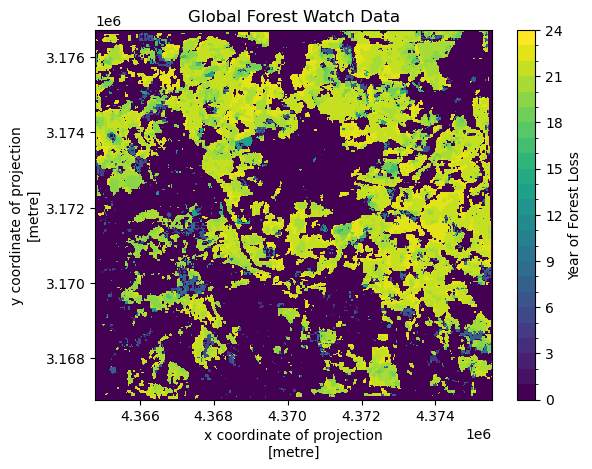

In [5]:
import rioxarray
import matplotlib.pyplot as plt

# Define bounding box in EPSG:4326 (lon/lat)
bbox_coords = [
    10.633501,
    51.611195,
    10.787234,
    51.698098,
]  # [min_x, min_y, max_x, max_y]
target_epsg = 3035  # ETRS89-LAEA (meters)

# Open the file (replace 'comp_data' with your raster file path)
ground_truth = (
    rioxarray.open_rasterio(comp_data)  # Replace with your file path
    .rio.clip_box(
        minx=bbox_coords[0],
        miny=bbox_coords[1],
        maxx=bbox_coords[2],
        maxy=bbox_coords[3],
    )
    .rio.reproject(target_epsg)
    .sel(band=1)
    .where(lambda gt: gt < 100, 0)  # Fill no-data (values > 100) with 0
)

# Plot
ground_truth.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch Data")
plt.show()

The data shows in which year forest was first lost. To compare with our own data, we need to add the data to our dataset. To do this the data needs to have the same coordinates. This can be achieved with `.interp_like()`. This function interpolates the data to match up the coordinates of another dataset.

In this case we chose the interpolation method `nearest` since it is categorical data.

The ground truth data saves the year when deforestation was first detected for a pixel in a single raster. To do this, it encodes the year of forest loss as an integer, giving the year. So, an integer 21 means the pixel was first detected as deforested in 2021, whereas a value of 0 means that deforestation was never detected.

Currently our classification saves the deforestation detection in multiple rasters, one for each year. To get our data into a format that is similar to our comparison data we need to convert our rasters for each time step into a single one.

To do this we first assign all pixels which were detected as deforestation (`CHANGE == -1`) to the year in which the deforestation was detected (`lost_year`). Then we compute over our time-series the first occurence of deforestation (equivalent to the first non-zero value) per pixel. This is then saved in a new data variable.

Comparing this visually to the Global Forest Watch data, allows us to do some initial quality assessment. We can see definite differences between the two datasets. The Global Forest Watch data has much more clearly defined borders. In general, our classification seems to overestimate deforestation. However, the general pattern of forest loss is the same in both. Most of the deforestation is in the north of the study area, with less forest loss in the south.

There are a few reasons for those differences. The main difference has to be in our much more simple approach to forest classification and change detection. It is expected that our approach will lead to large amounts of commission errors since changes are only confirmed using a single observation. It however can also lead to a lot of omission errors since the NDVI thresholding might classify highly productive non-forest areas as forest due to their high NDVI values. 

However, there are also some systematic differences. Our algorithm looks at differences between the middle of the years, which means that some changes can happen at the end of the growing year which will be detected first in the next year whereas the Global Forest Watch dataset will detect it in the correct (earlier) year.

Finally, we can also calculate an accuracy score. This is a score from 0-1, where values close to 0.5 basically mean that the classification is random, and values close to 1 mean that most of the values of our comparison data and classification data match.

First, we look at the overall accuracy of forest loss over the entire period from 2018 to 2023.

As expected from the visual interpretation, with an accuracy of 0.77, our product differs quite a lot compared to the Global Forest Watch data. From this we do not know for sure that our product is less accurate compared to the actual forest loss patterns observed on the ground. We only know that it is different to the Global Forest Watch product. It might be more or less accurate. 

However, because of the simplicity of our algorithm, it is safe to assume that our output is less accurate. 

## Summary

This notebook showed how to efficiently access data stored on the Copernicus Dataspace Ecosystem using the Sentinel Hub APIs. This includes generating cloud-free mosaics and calculating spectral indices in the cloud. 

It also showed how to import this data using xarray and carry out a basic multi-temporal detection of forest loss.

This notebook should serve as a starting point for your own analysis using the powerful Python Data Analysis ecosystem and leveraging the Copernicus Data Space Ecosystem APIs for quick satellite data access.

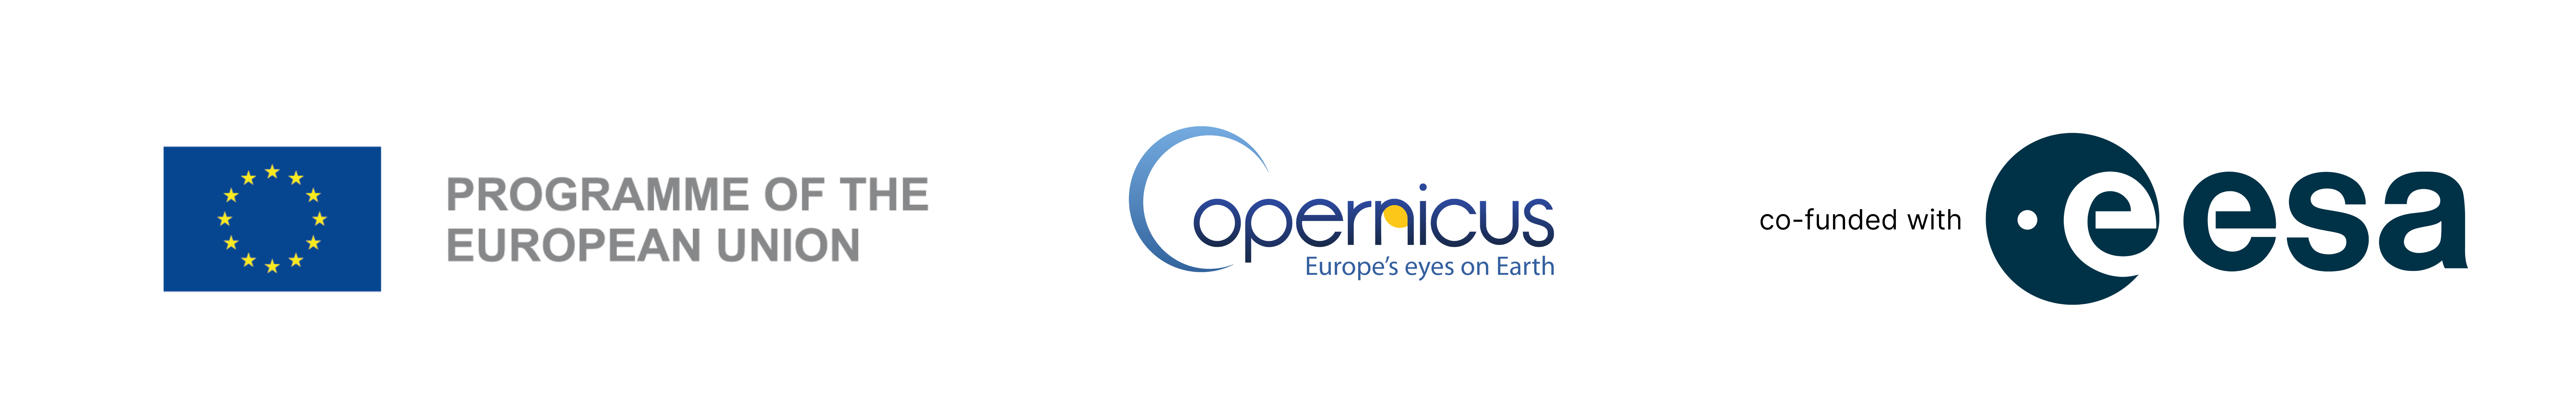